In [1]:
library(reticulate)
sagemaker  <- import('sagemaker')

In [2]:
session <- sagemaker$Session()
bucket <- session$default_bucket()

In [3]:
role_arn <- sagemaker$get_execution_role()

In [4]:
library(tidyverse)
library(modelr)

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [5]:
data_file <- 'data_airly.csv'
data_airly_all <- read_csv(file=data_file)#, col_types = cols("d", "d", "T", "c", "d", "d", "d"))
head(data_airly_all)

New names:
* `` -> ...1

Rows: 420484 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): status
dbl  (5): ...1, id, humidity, no2, temperature
dttm (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



...1,id,date,status,humidity,no2,temperature
<dbl>,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>
0,10566,2020-10-01 00:00:00,RAW,NA,NA,NA
1,10566,2020-10-01 00:05:00,RAW,NA,NA,NA
2,10566,2020-10-01 00:10:00,RAW,99.9939,299.4529,13.57765
3,10566,2020-10-01 00:15:00,RAW,NA,NA,NA
4,10566,2020-10-01 00:20:00,RAW,NA,NA,NA
5,10566,2020-10-01 00:25:00,RAW,99.9939,299.6364,13.19920


In [6]:
data_airly_all <- data_airly_all %>% 
  filter(date > "2021-01-01 00-00-00")

In [7]:
data_file <- 'data_ref.csv'
data_ref_all <- read_csv(file=data_file)
head(data_ref_all)

New names:
* `` -> ...1

Rows: 17521 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): status
dbl  (3): ...1, id, no2
dttm (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



...1,id,date,status,no2
<dbl>,<dbl>,<dttm>,<chr>,<dbl>
0,9629,2020-10-01 00:00:00,FINAL,NA
1,9629,2020-10-01 00:30:00,FINAL,13.387
2,9629,2020-10-01 01:00:00,FINAL,NA
3,9629,2020-10-01 01:30:00,FINAL,9.945
4,9629,2020-10-01 02:00:00,FINAL,NA
5,9629,2020-10-01 02:30:00,FINAL,10.136


In [8]:
data_ref_all <- data_ref_all %>% 
  filter(date > "2021-01-01 00-00-00")

In [9]:
insta_id = 10566    
data_id <- data_airly_all %>% 
  filter(id==insta_id) %>% 
  select(date, status, no2) %>% 
  pivot_wider(names_from = status, values_from = c(no2))

In [10]:
data_id_TRH <- data_airly_all %>% 
  filter(id==insta_id, status=="RAW") %>% 
  select(date, temperature, humidity)

In [11]:
install.packages("openair")

also installing the dependencies ‘jpeg’, ‘latticeExtra’, ‘mapproj’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [12]:
# find baseline points (taking minimum of RAW over 1hr intervals)
data_id_base <- data_id %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "min", start.date = "2021-01-01 00:00:00")

# find temperature points corresponding to baseline values (averaging over the same 1hr period)
data_id_TRH_mean <- data_id_TRH %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-01-01 00:00:00")

In [13]:
base_train <- cbind(data_id_base[,1:3], data_id_TRH_mean[,2:3])

In [14]:
base_train <- base_train %>%
  na.exclude()

model_poly <- lm(RAW ~ poly(temperature, 2), data=base_train)
summary(model_poly)


Call:
lm(formula = RAW ~ poly(temperature, 2), data = base_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.6627 -1.2309 -0.2882  0.9869 12.6091 

Coefficients:
                        Estimate Std. Error  t value Pr(>|t|)    
(Intercept)            300.29359    0.02481 12103.84   <2e-16 ***
poly(temperature, 2)1 -103.17744    2.00821   -51.38   <2e-16 ***
poly(temperature, 2)2  -36.03979    2.00821   -17.95   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.008 on 6549 degrees of freedom
Multiple R-squared:  0.3114,	Adjusted R-squared:  0.3112 
F-statistic:  1481 on 2 and 6549 DF,  p-value: < 2.2e-16


In [15]:
data_id_comb <- inner_join(data_id, data_id_TRH, by=c("date"="date"))

# add predictions of the model to the train data to find new baseline values 
data_id_comb <- data_id_comb %>% 
  add_predictions(model_poly, var = "baseline")# %>% 
#   add_residuals(model_poly)

In [16]:
#split data into training (first 1 month ~10%) and test (263 ~90%)
data_id_comb_train <- data_id_comb %>%
  filter(date < "2021-02-01 00-00-00")

test_id_comb <- data_id_comb %>%
  filter(date >= "2021-02-01 00-00-00")

data_ref_train <- data_ref_all %>%
  filter(date < "2021-02-01 00-00-00")

data_ref_test <- data_ref_all %>%
  filter(date >= "2021-02-01 00-00-00")

In [17]:
# average data over 1hr to reduce data points for final modeling
data_id_comb_1hr <- data_id_comb_train %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-01-01 00:00:00")

data_ref_1hr <- data_ref_train %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-01-01 00:00:00")

New names:
* ...1 -> ...3



In [18]:
# rebuild train dataset by combining airly and ref values
gas_train <- inner_join(data_id_comb_1hr, data_ref_1hr, by=c("date"="date")) %>% 
  mutate(diff = RAW-baseline)

In [19]:
head(gas_train)

date,RAW,AUX,PPB,FINAL,temperature,humidity,baseline,...3,id,no2,diff
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01 00:00:00,301.6565,295.3762,16.18659,22.11171,0.9836763,99.9939,301.6313,4417.0,9629,21.802,0.02522107
2021-01-01 01:00:00,301.6479,295.3802,16.18820,22.12773,0.8041268,99.9939,301.6301,4418.5,9629,22.185,0.01780901
2021-01-01 02:00:00,301.5348,295.2148,15.86725,21.81443,0.2618720,99.9939,301.6234,4420.5,9629,22.376,-0.08862935
2021-01-01 03:00:00,303.0094,295.4253,24.95246,32.00697,0.3561204,99.9939,301.6253,4422.5,9629,21.038,1.38408548
2021-01-01 04:00:00,302.4175,295.5368,20.74644,27.23084,0.9716419,99.9939,301.6310,4424.5,9629,27.540,0.78645473
2021-01-01 05:00:00,302.1319,295.5355,18.70853,24.90439,1.5118670,99.9939,301.6327,4426.5,9629,23.524,0.49918058


In [20]:
gas_train <- gas_train %>% 
    select(no2, diff, temperature) %>% 
    na.exclude()

In [21]:
write_csv(gas_train, 'gas_train.csv', col_names=FALSE)

In [22]:
s3_train <- session$upload_data(path='gas_train.csv',
                               bucket=bucket,
                               key_prefix='r_demo2/data')
s3_path  <- paste('s3://',bucket,'/r_demo2/data/gas_train.csv',sep = '')
cat('Your CSV data is stored on S3 in this location:\n',s3_path)

Your CSV data is stored on S3 in this location:
 s3://sagemaker-eu-west-2-870953422121/r_demo2/data/gas_train.csv

In [23]:
# average data over 1hr to reduce data points to match train set processing
test_id_comb_1hr <- test_id_comb %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-02-01 00:00:00")

test_ref_1hr <- data_ref_test %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-02-01 00:00:00")

gas_test <- inner_join(test_id_comb_1hr, na.omit(test_ref_1hr), by=c("date"="date")) %>% 
  mutate(diff = RAW-baseline)

New names:
* ...1 -> ...3



In [24]:
head(gas_test)

date,RAW,AUX,PPB,FINAL,temperature,humidity,baseline,...3,id,no2,diff
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-02-01 00:00:00,301.2820,295.4565,12.62891,17.72045,4.312795,99.9939,301.5885,5904.5,9629,11.092,-0.3064992
2021-02-01 01:00:00,301.1125,295.3692,11.89822,16.94076,4.045697,99.9939,301.5965,5906.5,9629,12.431,-0.4840132
2021-02-01 02:00:00,301.6948,295.5101,15.04945,20.36362,4.127098,99.9939,301.5941,5908.5,9629,15.109,0.1007314
2021-02-01 03:00:00,301.7674,295.5680,15.18113,20.48384,4.577157,99.9939,301.5798,5910.5,9629,15.874,0.1876387
2021-02-01 04:00:00,301.4561,295.4974,13.46290,18.62123,4.660459,99.9939,301.5768,5912.5,9629,14.535,-0.1206742
2021-02-01 05:00:00,302.5503,295.5166,19.90419,25.60976,4.856866,99.9939,301.5697,5914.5,9629,18.934,0.9805720


In [25]:
gas_test <- gas_test %>%
     select(no2, diff, temperature) %>% 
    na.exclude()

In [26]:
write_csv(gas_test[-1], 'gas_test.csv', col_names=FALSE)

In [27]:
s3_test <- session$upload_data(path='gas_test.csv',
                               bucket=bucket,
                               key_prefix='r_demo2/data')
s3_path  <- paste('s3://',bucket,'/r_demo2/data/gas_test.csv',sep = '')
cat('Your CSV data is stored on S3 in this location:\n',s3_path)

Your CSV data is stored on S3 in this location:
 s3://sagemaker-eu-west-2-870953422121/r_demo2/data/gas_test.csv

In [28]:
s3_train_input <- sagemaker$inputs$TrainingInput(s3_data=s3_train,
                                                content_type='text/csv')

In [29]:
container <- sagemaker$image_uris$retrieve(framework='linear-learner',
                                          region=session$boto_region_name, 
                                          version='latest')
cat('Linear Container Image URL: ', container)

Linear Container Image URL:  644912444149.dkr.ecr.eu-west-2.amazonaws.com/linear-learner:1

In [30]:
# Model artifacts and batch output
s3_output <- paste('s3:/', bucket, 'r_demo2','output', sep = '/')

In [31]:
# Estimator
estimator <- sagemaker$estimator$Estimator(image_uri = container,
                                           role = role_arn,
                                           train_instance_count = 1L,
                                           train_instance_type = 'ml.m5.4xlarge',
                                           output_path = s3_output,
                                           sagemaker_session = NULL)

In [32]:
estimator$set_hyperparameters(predictor_type="regressor",
                             mini_batch_size=100L)

In [33]:
# create a training job name
job_name <- paste('sagemaker-r-linear', format(Sys.time(), '%H-%M-%S'), sep='-')

# Define the data channels for train and validation datasets
input_data <- list('train'=s3_train_input)

# train the estimator
estimator$fit(inputs=input_data, job_name=job_name)

In [34]:
# define s3 path for test data
s3_test_url <- paste('s3:/', bucket, 'r_demo2', 'data', 'gas_test.csv', sep='/')

In [35]:
# define a transformer
transformer <- estimator$transformer(instance_count=1L,
                                    instance_type='ml.m5.4xlarge',
#                                     strategy="MultiRecord",
                                    output_path=s3_output)

In [36]:
# do the batch transform
transformer$transform(s3_test_url,
                      content_type="text/csv",
#                       split_type="Line",
                      wait=TRUE)

In [37]:
# Download the file from S3 using S3Downloader to local SageMaker instance 'batch_output' folder
sagemaker$s3$S3Downloader$download(paste(s3_output,"gas_test.csv.out",sep = '/'),
                          "batch_output")

In [38]:
predictions <- read_csv(file='batch_output/gas_test.csv.out',
                       col_names='predicted_no2')
head(predictions)

Rows: 4516 Columns: 1

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): predicted_no2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



predicted_no2
<chr>
"{""score"":11.264664649963379}"
"{""score"":10.378288269042969}"
"{""score"":13.859935760498047}"
"{""score"":14.06920337677002}"
"{""score"":12.144645690917969}"
"{""score"":18.671279907226562}"


In [39]:
# Concatenate predictions and test for comparison
gas_predictions <- cbind(predicted_no2 = predictions$predicted_no2,
                      gas_test)
# Convert predictions to Integer
gas_predictions$predicted_no2 = extract_numeric(gas_predictions$predicted_no2);
head(gas_predictions)

extract_numeric() is deprecated: please use readr::parse_number() instead



,predicted_no2,no2,diff,temperature
,<dbl>,<dbl>,<dbl>,<dbl>
1,11.26466,11.092,-0.3064992,4.312795
2,10.37829,12.431,-0.4840132,4.045697
3,13.85994,15.109,0.1007314,4.127098
4,14.06920,15.874,0.1876387,4.577157
5,12.14465,14.535,-0.1206742,4.660459
6,18.67128,18.934,0.9805720,4.856866


In [40]:
# define a function to calculate RMSE
rmse <- function(m, o){
    sqrt(mean((m-o)^2))
}

In [41]:
# calculate RMSE
gas_rmse <- rmse(gas_predictions$no2, gas_predictions$predicted_no2)
cat('RMSE for Batch Transform: ', round(gas_rmse, digits=2))

RMSE for Batch Transform:  8.95

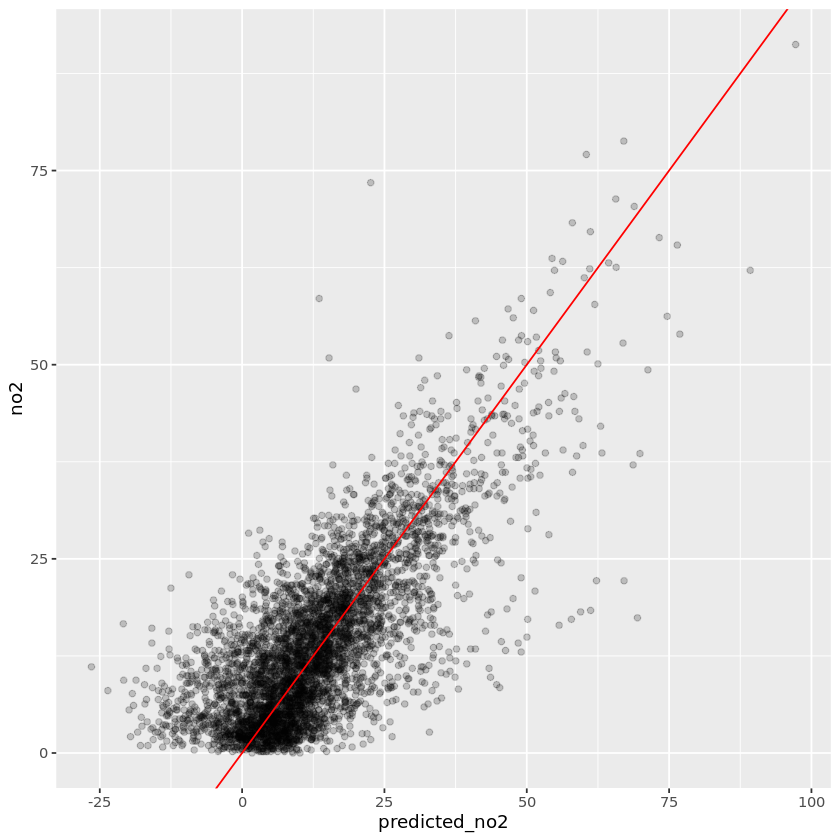

In [42]:
gas_predictions %>% 
    ggplot(aes(x=predicted_no2, y=no2)) +
    geom_point(alpha=0.2) +
    geom_abline(slope=1, intercept=0, col="red")

In [43]:
# deploy trained model
model_endpoint <- estimator$deploy(initial_instance_count=1L,
                              instance_type='ml.t2.medium')

In [44]:
model_endpoint$serializer <- sagemaker$serializers$CSVSerializer(content_type='text/csv')

In [45]:
test_sample <- as.matrix(gas_test[-1])
dimnames(test_sample)[[2]] <- NULL

In [46]:
predictions_ep <- model_endpoint$predict(test_sample)

In [47]:
json <- reticulate::import("json")

In [48]:
temp <- json$loads(predictions_ep)
temp <- as_tibble(temp)

In [49]:
temp <- sapply(temp, extract_numeric)

extract_numeric() is deprecated: please use readr::parse_number() instead



In [50]:
# predictions_ep1 <- str_split(predictions_ep, pattern = ',', simplify = TRUE)

In [51]:
# predictions_ep2 <- sapply(X = predictions_ep1, FUN = parse_number)

In [52]:
# attr(predictions_ep2, "names") <- NULL

In [53]:
# Convert predictions to Integer
gas_predictions_ep <- cbind(temp,
                      gas_test)
# abalone_predictions = as.integer(abalone_predictions)
head(gas_predictions_ep)

,predictions,no2,diff,temperature
,<dbl>,<dbl>,<dbl>,<dbl>
1,11.26466,11.092,-0.3064992,4.312795
2,10.37829,12.431,-0.4840132,4.045697
3,13.85994,15.109,0.1007314,4.127098
4,14.06920,15.874,0.1876387,4.577157
5,12.14465,14.535,-0.1206742,4.660459
6,18.67128,18.934,0.9805720,4.856866


In [54]:
# Calucalte RMSE
gas_rmse_ep <- rmse(gas_predictions_ep$no2, gas_predictions_ep$predictions)
cat('RMSE for Endpoint 500-Row Prediction: ', round(gas_rmse_ep, digits = 2))

RMSE for Endpoint 500-Row Prediction:  8.95

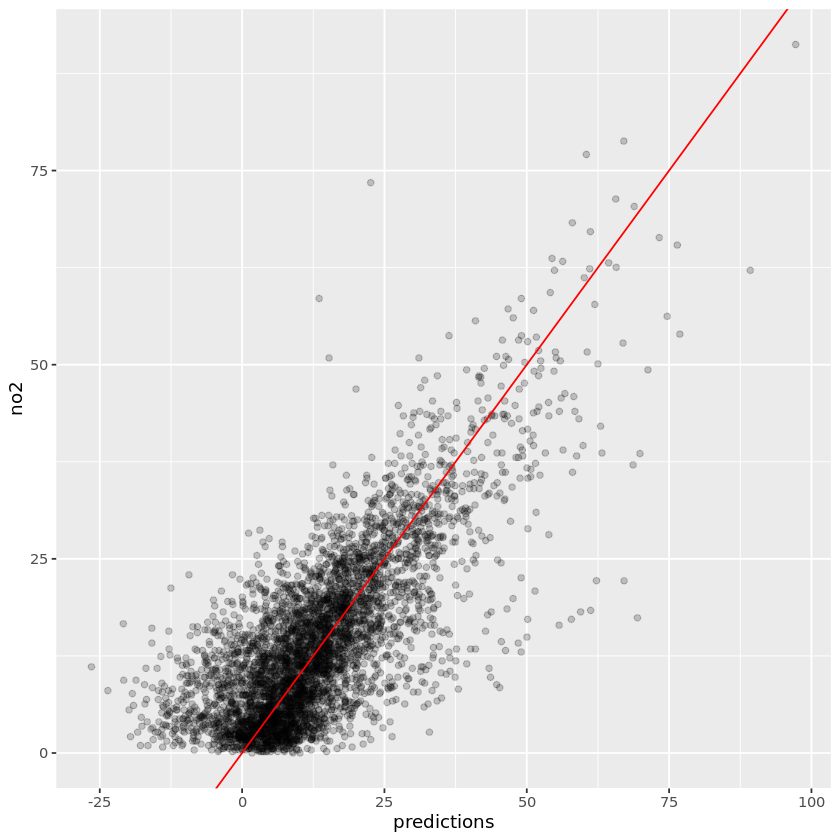

In [55]:
gas_predictions_ep %>% 
    ggplot(aes(x=predictions, y=no2)) +
    geom_point(alpha=0.2) +
    geom_abline(slope=1, intercept=0, col="red")

In [ ]:
# When you’re done with the model, delete the endpoint to avoid incurring deployment costs:
session$delete_endpoint(model_endpoint$endpoint)